In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
print(tf.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

2.5.0


## Подготовка данных


In [ ]:
train_data = pd.read_csv('train_data.txt', header=None, sep=":::", engine='python')
train_data.rename(columns={0: "ID", 1: "TITLE", 2: "GENRE", 3: "DESCRIPTION"}, inplace=True)
test_data = pd.read_csv('test_data_solution.txt', header=None, sep=":::", engine='python')
test_data.rename(columns={0: "ID", 1: "TITLE", 2: "GENRE", 3: "DESCRIPTION"}, inplace=True)

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import string

# дополнительный словарь со знаками пунктуации
nltk.download('punkt', download_dir='.')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to ....
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# стоп слова
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
    'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'shold',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "'s", "''", '``'
]

#### Разбиение на строки и очистка текста

In [ ]:
def tokenize_text(raw_text: str):
    """Функция для токенизации текста

    :param raw_text: исходная текстовая строка
    """
    tokenized_str = nltk.word_tokenize(raw_text)  # разделяем текст на токены
    tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]  # приводим к нижнему регистру и удаляем пунктуацию
    filtered_tokens = [i for i in tokens if ( i not in stop_words )]  # удаляем стоп слова
    filtered_and_lemmatized_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens] # лематимизируем слова
    return filtered_and_lemmatized_tokens

copy_train_data = train_data.copy()
tokenized_data = copy_train_data.DESCRIPTION.apply(tokenize_text)

In [ ]:
tokenized_word_array = np.array([i for i in tokenized_data])
tokenized_word_list = []
for i in tokenized_data:
    tokenized_word_list += i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
len(set(tokenized_word_list))

139172

#### Отбор наиболее распространенных токенов

In [ ]:
from collections import Counter
most_common_words = Counter(tokenized_word_list).most_common(9997)
most_common_words = [i for i, k in most_common_words]

#### Нумерация строк

In [ ]:
word_index = {}
word_num = -1
for i in most_common_words:
    word_num += 1
    word_index[i] = word_num

In [ ]:
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# последовательность индексов в текст
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# текст в последовательность индексов
def encode_review(words):
    words = ['<START>'] + words
    idxs = [word_index.get(word, word_index['<UNKNOWN>']) for word in words]
    return idxs

In [ ]:
train_data_x = train_data.copy().DESCRIPTION.apply(tokenize_text)
test_data_x = test_data.copy().DESCRIPTION.apply(tokenize_text)

In [ ]:
print('Example of a encoded review: \n{}'.format(encode_review(test_data_x[4])))

Example of a encoded review: 
[1, 211, 4122, 2061, 123, 2546, 2922, 891, 3099, 4470, 2217, 2225, 5, 35, 156, 2, 4, 379, 5, 2, 8228, 7041, 2, 35, 1292, 5, 5258, 11, 7856, 821, 1009, 1666, 278, 8036, 2, 701, 546, 620, 8778, 2922, 891, 197, 2, 1361, 156, 2, 2, 2, 2626, 8225, 5, 2044, 73, 5438, 6143, 646, 2, 825, 2, 43, 2, 3548, 4710, 1698, 9356, 205, 446, 174, 120, 4088, 396, 28, 1119, 51, 478, 6143, 544, 3027, 147, 2554, 3521, 237, 2922, 891, 153, 6407, 42, 3318, 2, 3548, 2]


In [ ]:
train_data_x

0        [listening, conversation, doctor, parent, 10-y...
1        [brother, sister, past, incestuous, relationsh...
2        [bus, empty, student, field, trip, museum, nat...
3        [help, unemployed, father, make, end, meet, ed...
4        [film, title, refers, un-recovered, body, grou...
                               ...                        
54209    [short-lived, nbc, live, sitcom, centered, bon...
54210    [next, generation, exploitation, sister, kapa,...
54211    [ze, bestaan, echt, stand-up, comedy, growing,...
54212    [walter, vivian, live, country, difficult, tim...
54213    [labor, day, weekend, 1935, intense, hurricane...
Name: DESCRIPTION, Length: 54214, dtype: object

In [ ]:
list_train_data = []
for i in range(len(train_data_x)):
    list_train_data.append(encode_review(train_data_x[i]))
list_test_data = []
for i in range(len(test_data_x)):
    list_test_data.append(encode_review(test_data_x[i]))

In [ ]:
train_data_array = np.array(list_train_data, dtype='object')
test_data_array = np.array(list_test_data, dtype='object')

In [ ]:
train_data_y = train_data.copy().GENRE.values
test_data_y = test_data.copy().GENRE.values

In [ ]:
genre_index = {}
genre_num = -1
for i in set(train_data_y):
    genre_num += 1
    genre_index[i] = genre_num

genre = {v: k for k, v in genre_index.items()}

def encode_genre(genre_index, genres_list):
    encoded_genres_list = [genre_index[i] for i in genres_list]
    return np.array(encoded_genres_list)

In [ ]:
train_y_data = encode_genre(genre_index, train_data_y)
test_y_data = encode_genre(genre_index, test_data_y)

In [ ]:
MAX_SEQ_LEN = 48 # Финальная длина последовательности

train_x_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data_array,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

test_x_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data_array,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

print("Length examples: {}".format([len(train_x_data[0]), len(train_x_data[1])]))
print('=====================================')
print("Entry example: {}".format(train_x_data[0]))

Length examples: [48, 48]
Entry example: [ 132 7851 2537  366 1989 1333   65  345   62 3984  670 1342  745 1699
    2 1108  443 4527   41  450 7508  758  916 1108  742 9322  117  516
 5148 1602 2845 2352 1712 2537   62    3   14  349  210   19 1182    2
    2    2  392 2301 6663  850]


In [ ]:
train_x_data[5]

array([1161, 3711,    2, 1860, 4813, 2302, 1777,    5,  206,    2,    2,
       2059,    2, 2084,  295,  232,  298,   34,  306,  574,    2, 1076,
        507,  707, 1693,  206, 1015, 1386, 1007,  232,    5,  345, 2810,
       3419, 3127, 1215,    2, 1153,   15,  476, 5905, 2666,  502,  704,
          2, 5097, 8091,    2], dtype=int32)

In [ ]:
max_len = 0
for i in range(len(train_data_array)):
    len_ = len(train_data_array[i])
    if len_ > max_len:
        max_len = len_
len_

32

#### Создание модели

In [ ]:
EMB_SIZE = 64 # Размер векторного представления (эмбеддинга)
VOCAB_SIZE = 10000
    
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.4)),
    tf.keras.layers.Dense(len(genre_index), activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 256)         197632    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_2 (Dense)              (None, 27)                6939      
Total params: 1,238,811
Trainable params: 1,238,811
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from pathlib import Path
path = Path("/content/drive/My Drive/Skillbox/class_text_model")
path.mkdir(exist_ok=True, parents=True) # папка создается на вашем гугл диске. вместе с "родителями"
assert path.exists()
cpt_filename = "checkpoint_best.h5"
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

In [ ]:
!pip install livelossplot
from livelossplot.inputs.tf_keras import PlotLossesCallback

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#### Обучение

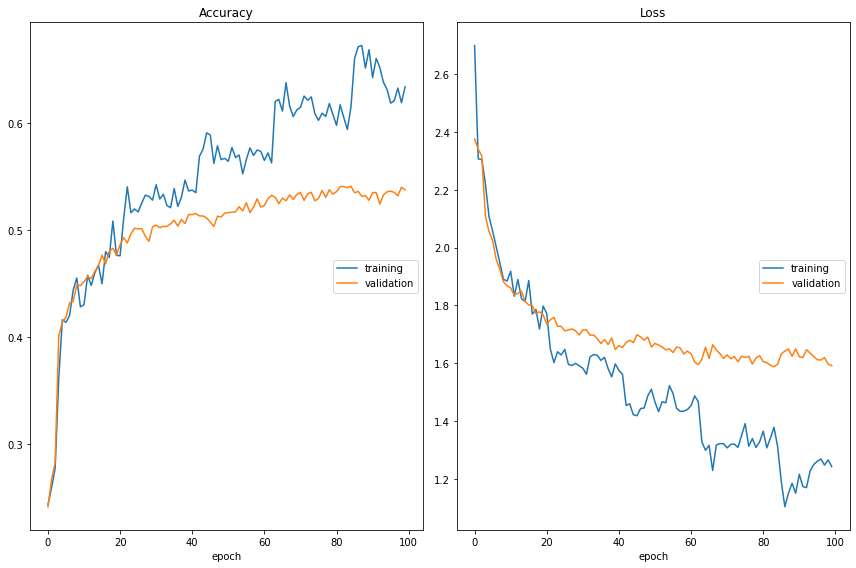

Accuracy
	training         	 (min:    0.243, max:    0.673, cur:    0.634)
	validation       	 (min:    0.242, max:    0.541, cur:    0.538)
Loss
	training         	 (min:    1.104, max:    2.699, cur:    1.243)
	validation       	 (min:    1.588, max:    2.375, cur:    1.592)


In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 100

history = model.fit(train_x_data,
                    train_y_data,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(test_x_data, test_y_data),
                    steps_per_epoch=20,
                    callbacks=[PlotLossesCallback(), checkpoint])

#### Инференс

In [ ]:
def pred_genre_movie(text: str):
    tokenized_text = tokenize_text(text)
    encoded_text = encode_review(tokenized_text)
    predicted_genre = np.argmax(model.predict(np.array(encoded_text)[None, :]))
    return predicted_genre

In [ ]:
text = "It was the most scary movie I have ever seen"
pred_genre_movie(text)

' horror '